# Assignment 9
For this assignment, we will examine our keras MNIST network, and try to optimize it.

Tasks:
1.   Add k-fold validation (with 4 folds) to your network testing.  It would be best if you put this in a callable module - a skeleton of such code will be given below.
2.   Optimize the network for the number of hidden nodes in the hidden layer: test the following choices: 50,100,500,800.   Use validation loss to pick the best choise.
    * Use short=True at first while setting your code up and testing it.   Once it is ready to go then set short=False.   With short=False, the full run over all node coices will tak about 10-15 minutes.
    * Make sure you call:
    
        network.load_weights('model_init.h5')
    
    before fitting the network for each k-fold in the k-fold loop.   Do you know why this is necessary?
    
3.   Test the performance of your fully-trained network using the best hidden node choice above (after k-fold validation) on the separate test sample.  You will need to retrain on the full sample using the best hiden node choice.   Note that you can put the **test** sample in as the **validation** sample in re-fitting the full network. 
    *  Get the overall performance
    *  Plot the loss and accuracy of the train and test sample versus epoch.
    *  Calculate the confusion matrix on the test sample.

4. Generate a sample of 7000 random images of size 28x28.   Feed these to the network:   How does the network classify them?

**Extra**:  
1. How confident is the network when it gets the prediction correct?  How about when it gets the prediction incorrect?   
    * Make a plot which compares these two cases. 
2.  Add the random data to your training set (use the best hiden node choice) and train the data.   What does the full confusion matrix look like for this case?

## Get the data and prepare it

In [29]:
from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

short = False # remember to change this to False when you are ready to do the full assignment
if short:
    train_images = train_images[:7000,:]
    train_labels = train_labels[:7000]
    test_images = test_images[:3000,:]
    test_labels = test_labels[:3000]
#
print("Train info",train_images.shape, train_labels.shape)
print("Test info",test_images.shape, test_labels.shape)

train_images = train_images.reshape((train_images.shape[0],28*28))
train_images = train_images.astype('float32')/255

test_images = test_images.reshape((test_images.shape[0],28*28))
test_images = test_images.astype('float32')/255

from keras.utils import to_categorical

train_labels_cat = to_categorical(train_labels)
test_labels_cat = to_categorical(test_labels)


Train info (60000, 28, 28) (60000,)
Test info (10000, 28, 28) (10000,)


## Task 1: add k-fold validation using a method

In [2]:
from keras import models
from keras import layers
from keras import models
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
import numpy as np

def kfold_network(hidden_nodes,activation='tanh',optimizer='adam'):

    network = models.Sequential()
    network.add(layers.Dense(hidden_nodes,activation=activation,input_shape=(28*28,)))
    network.add(layers.Dense(10,activation='softmax'))

    network.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
#
# Save the weights - which are just random initialization because we have not trained
# the network yet.  
# If we reload this below right before fitting the model, the model will start from scratch
    network.save_weights('model_init.h5')
#
# Early stopping
    patienceCount = 10
    callbacks = [EarlyStopping(monitor='val_loss', patience=patienceCount),
                 ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
#
# Add loop over k-folds here ==> use 4 folds
    kfolds = 4
    skf = StratifiedKFold(n_splits=kfolds)
    
    avg_acc_test = 0.0
    avg_acc_train = 0.0
    avg_loss_test = 0.0
    avg_loss_train = 0.0
    avg_epochs = 0.0
    numSplits = 0.0
    
    for train_index, test_index in skf.split(train_images, train_labels):
        print("Training")
        X_train = train_images[train_index]
        y_train = to_categorical(train_labels[train_index])
        X_test = train_images[test_index]
        y_test = to_categorical(train_labels[test_index])
        

        
        network.load_weights('model_init.h5')
        history = network.fit(X_train,y_train,
                                      epochs=50,
                                      batch_size=128,
                                      verbose=0, # set to 0 for no printout while running
                                      callbacks=callbacks, # Early stopping
                                      validation_data=(X_test,y_test))
        
        training_vals_acc = history.history['acc']
        training_vals_loss = history.history['loss']
        valid_vals_acc = history.history['val_acc']
        valid_vals_loss = history.history['val_loss']
        
        avg_epochs += len(training_vals_acc) - patienceCount
        
        avg_acc_train += training_vals_acc[-patienceCount]
        avg_loss_train += training_vals_loss[-patienceCount]
        
        avg_acc_test += valid_vals_acc[-patienceCount]
        avg_loss_test += valid_vals_loss[-patienceCount]
    
        numSplits += 1.0
        
    avg_acc_test /= (numSplits)
    avg_acc_train /= (numSplits)
    
    avg_loss_test /= (numSplits)
    avg_loss_train /= (numSplits)
    
    avg_epochs /= (numSplits)
    

#
# Return the average accuracy and loss (on the validation sample!)
    return avg_acc_test,avg_acc_train,avg_loss_test,avg_loss_train,avg_epochs

## Task 2: Loop over hidden nodes and store results

In [3]:
#
# Determine best number of hidden nodes
avg_acc__train_list = []
avg_loss_train_list = []

avg_acc__test_list = []
avg_loss_test_list = []

avg_epochs_list =[]

for nodes in [50,100,500,800]:
    avg_acc_test,avg_acc_train,avg_loss_test,avg_loss_train,avg_epochs = kfold_network(nodes)
    
    avg_acc__train_list.append(avg_acc_train)
    avg_loss_train_list.append(avg_loss_train)

    avg_acc__test_list.append(avg_acc_test)
    avg_loss_test_list.append(avg_loss_test)
    
    avg_epochs_list.append(avg_epochs)
    


Training
Training
Training
Training
Training
Training
Training
Training
Training
Training
Training
Training
Training
Training
Training
Training


In [4]:
def enable_plotly_in_cell():
  import IPython
  from plotly.offline import init_notebook_mode
#
# OLD (google colab)
#  display(IPython.core.display.HTML('''
#        <script src="/static/components/requirejs/require.js"></script>
#  '''))
#  init_notebook_mode(connected=False)
#
# New (OSC) [thanks to Stephen Gant for this!]
  init_notebook_mode(connected=True)

from plotly.offline import iplot
import plotly.graph_objs as go
import numpy as np

enable_plotly_in_cell()
#
# Costs
data1 = go.Scatter(
    x=np.array([50,100,500,800]),
    y=avg_acc__test_list,
    mode='lines',
    name="Avg Test Accuracy"
)
iplot(dict(data=[data1]))

data2 = go.Scatter(
    x=np.array([50,100,500,800]),
    y=avg_loss_test_list,
    mode='lines',
    name="Avg Test Loss"
)

iplot(dict(data=[data2]))

data3 = go.Scatter(
    x=np.array([50,100,500,800]),
    y=avg_epochs_list,
    mode='lines',
    name="Average N Epochs"
)
iplot(dict(data=[data3]))

## Task 3: Pick the best model and retrain the network with the full data
Things to keep in mind here:
*  Stop training at the average epoch for the best node choice (don't use early stopping)
*  Use the full training sample
*  Don't include a validation set
*  Remember to save your network

In [5]:
hidden_nodes = 500
n_epochs = 12
activation = 'tanh'
optimizer = 'adam'

network_best = models.Sequential()
network_best.add(layers.Dense(hidden_nodes,activation=activation,input_shape=(28*28,)))
network_best.add(layers.Dense(10,activation='softmax'))

network_best.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

network_best.save_weights('model_init_best.h5')

network_best.load_weights('model_init_best.h5')

history_best = network_best.fit(train_images, train_labels_cat,epochs=n_epochs,batch_size=128,verbose=0) 

network_best.save('fully_trained_model_best.h5')

## Task 4: Generate a sample of 1000 random images of size 28x28 and feed these to the network.
You can generate these with one line using numpy!  How does the network classify them?   You can just use a defaultdict to count the predicted class.

# First I will test on test set

In [6]:
from collections import defaultdict
from functools import partial
from itertools import repeat

def nested_defaultdict(default_factory, depth=1):
    result = partial(defaultdict, default_factory)
    for _ in repeat(None, depth - 1):
        result = partial(defaultdict, result)
    return result()
  

#
# Determine the performance
def multiPerformance(y,y_pred):

    confusionMatrix = nested_defaultdict(int,2)
    classes = set()
    totalTrue = defaultdict(int)
    totalPred = defaultdict(int)
    for i in range(len(y_pred)):
        trueClass = y[i]
        classes.add(trueClass)
        predClass = y_pred[i]
        totalTrue[trueClass] += 1
        totalPred[predClass] += 1
        confusionMatrix[trueClass][predClass] += 1
    return confusionMatrix

In [7]:
from keras.models import load_model

trained_network = load_model('fully_trained_model_best.h5')

test_loss, test_acc = trained_network.evaluate(test_images,test_labels_cat)
print("Test sample loss: ",test_loss, "; Test sample accuracy: ",test_acc)

predictions = trained_network.predict(test_images)

probs = np.max(predictions, axis = 1)

classes = np.argmax(predictions, axis = 1)

CM = multiPerformance(test_labels,classes)
print("Test confusion matrix")
for trueClass in range(10):
    print("True: ",trueClass,end="")
    for predClass in range(10):
        print("\t",CM[trueClass][predClass],end="")
    print()
print()


10000/10000 [==============================] - 0s 22us/step
Test sample loss:  0.06707037228294649 ; Test sample accuracy:  0.979
Test confusion matrix
True:  0	 969	 0	 3	 1	 1	 1	 1	 1	 3	 0
True:  1	 0	 1120	 5	 1	 0	 1	 2	 2	 4	 0
True:  2	 3	 0	 1013	 1	 1	 0	 2	 5	 7	 0
True:  3	 0	 0	 4	 984	 0	 2	 0	 3	 4	 13
True:  4	 0	 0	 5	 0	 968	 0	 2	 1	 1	 5
True:  5	 1	 0	 0	 11	 2	 859	 5	 1	 7	 6
True:  6	 6	 3	 4	 1	 3	 4	 936	 0	 1	 0
True:  7	 1	 0	 7	 1	 3	 0	 0	 1009	 2	 5
True:  8	 3	 0	 5	 4	 4	 3	 1	 4	 946	 4
True:  9	 2	 2	 0	 2	 9	 2	 0	 6	 0	 986



# Generate Random images

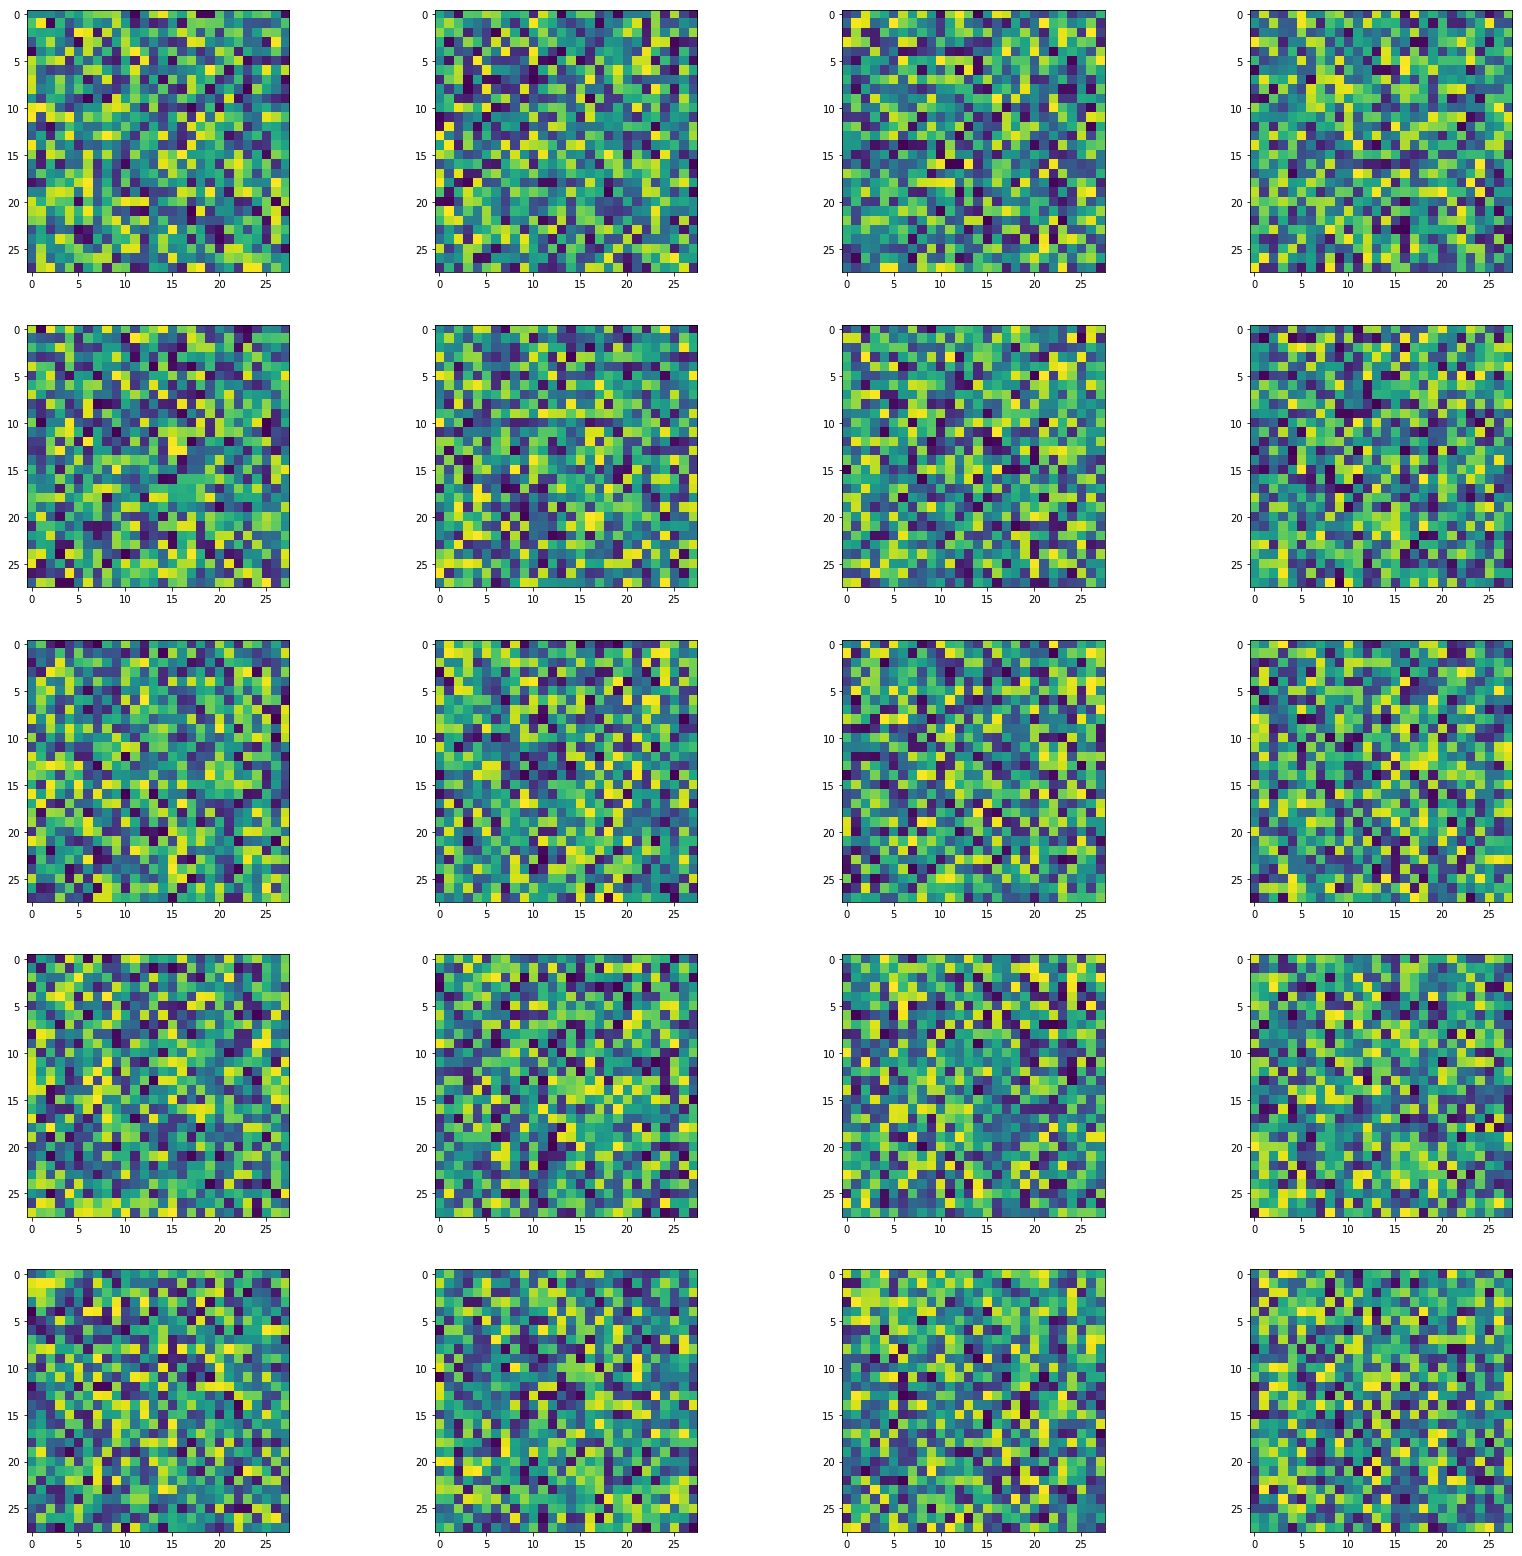

In [25]:
random_images = np.random.rand(7000,784)

import matplotlib.pyplot as plt

fig=plt.figure(figsize=(28, 28))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = random_images[i]
    img = img.reshape(28,28)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

# Classify images

In [27]:
trained_network_rand = load_model('fully_trained_model_best.h5')

predictions_rand = trained_network_rand.predict(random_images)

probs_rand = np.max(predictions_rand, axis = 1)

classes_rand = np.argmax(predictions_rand, axis = 1)

label_count = defaultdict(int)
for i in classes_rand:
    label_count[i] += 1

print(label_count)

defaultdict(<class 'int'>, {5: 6183, 3: 706, 2: 108, 7: 3})


# It thinks that we only have 2 classes: 5's and 3's. Mostly 5's

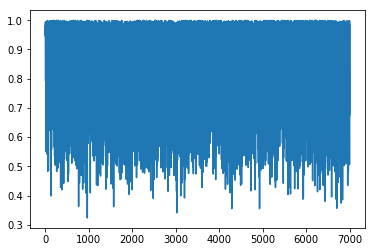

In [28]:
import matplotlib.pyplot as plt

plt.plot(probs_rand)

plt.show()

# It is also predicting with quite a bit of confidence. Most probabilities are higher that 0.5.

# Extra Stuff: Tried a different distribution

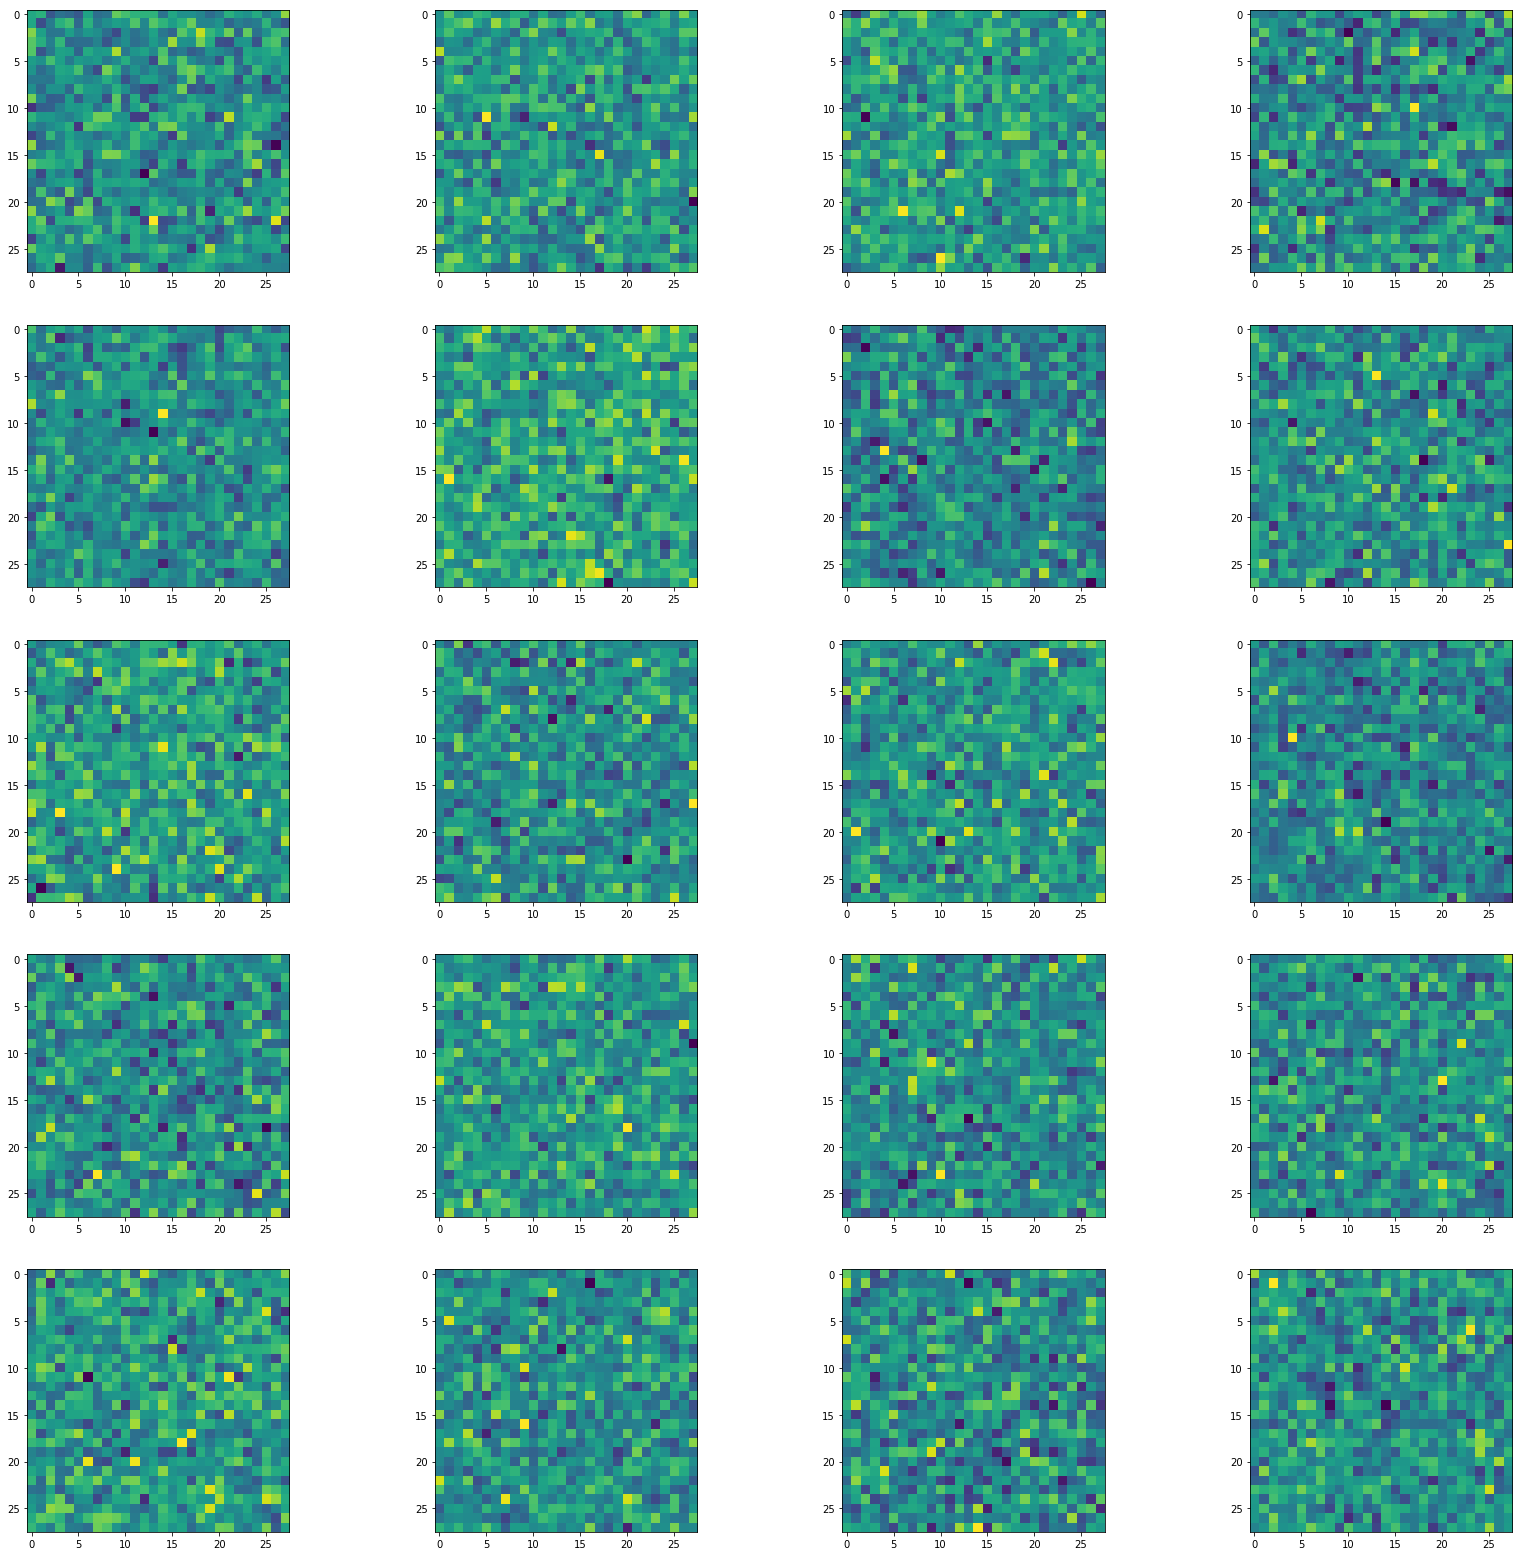

In [11]:
import numpy as np
import matplotlib.pyplot as plt

gaussian = np.random.normal(size = (7000,784), loc = 0.5, scale = 0.05)

fig=plt.figure(figsize=(28, 28))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = gaussian[i]
    img = img.reshape(28,28)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [12]:
from collections import defaultdict
from keras.models import load_model

trained_network_gau = load_model('fully_trained_model_best.h5')

predictions_gau = trained_network_gau.predict(gaussian)

probs_gau = np.max(predictions_gau, axis = 1)

classes_gau = np.argmax(predictions_gau, axis = 1)

label_count = defaultdict(int)
for i in classes_gau:
    label_count[i] += 1

print(label_count)

defaultdict(<class 'int'>, {5: 7000})


# Somehow it is more sure there is only fives

# I will now do the extra work:

In [13]:
trained_network = load_model('fully_trained_model_best.h5')

test_loss, test_acc = trained_network.evaluate(test_images,test_labels_cat)
print("Test sample loss: ",test_loss, "; Test sample accuracy: ",test_acc)

predictions = trained_network.predict(test_images)

probs = np.max(predictions, axis = 1)

classes = np.argmax(predictions, axis = 1)

CM = multiPerformance(test_labels,classes)
    

10000/10000 [==============================] - 0s 25us/step
Test sample loss:  0.06707037228294649 ; Test sample accuracy:  0.979


In [14]:
wrong = []
right = []

for i in range(len(classes)):
    if classes[i] == test_labels[i]:
        right.append(probs[i])
    else:
        wrong.append(probs[i])

print("The Mean confidence for correct class is:", np.mean(right))  
print("The Mean confidence for wrong class is:", np.mean(wrong)) 
data1 = go.Scatter(
    x=np.array(range(len(right))),
    y=right,
    mode='markers',
    name="Right Confidence"
)
iplot(dict(data=[data1]))

data2 = go.Scatter(
    x=np.array(range(len(wrong))),
    y=wrong,
    mode='markers',
    name="Right Confidence"
)

iplot(dict(data=[data2]))

The Mean confidence for correct class is: 0.9907807
The Mean confidence for wrong class is: 0.74857265


# Clearly, it is more confident when it guessed the correc class than when it guessed the wrong class. By almost a 20% margin.

In [15]:
from sklearn.utils import shuffle

random_images = np.random.rand(6000,784)

X = np.append(train_images,random_images, axis =0)
y = np.append(train_labels,np.zeros(6000)+10)

X_Train,y_Train = shuffle(X, y, random_state=42)

In [16]:
def kfold_network(hidden_nodes,activation='tanh',optimizer='adam'):

    network = models.Sequential()
    network.add(layers.Dense(hidden_nodes,activation=activation,input_shape=(28*28,)))
    network.add(layers.Dense(11,activation='softmax'))

    network.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
#
# Save the weights - which are just random initialization because we have not trained
# the network yet.  
# If we reload this below right before fitting the model, the model will start from scratch
    network.save_weights('model_init.h5')
#
# Early stopping
    patienceCount = 10
    callbacks = [EarlyStopping(monitor='val_loss', patience=patienceCount),
                 ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
#
# Add loop over k-folds here ==> use 4 folds
    kfolds = 4
    skf = StratifiedKFold(n_splits=kfolds)
    
    avg_acc_test = 0.0
    avg_acc_train = 0.0
    avg_loss_test = 0.0
    avg_loss_train = 0.0
    avg_epochs = 0.0
    numSplits = 0.0
    
    for train_index, test_index in skf.split(X_Train, y_Train):
        print("Training")
        X_train = X_Train[train_index]
        y_train = to_categorical(y_Train[train_index])
        X_test = X_Train[test_index]
        y_test = to_categorical(y_Train[test_index])
        

        
        network.load_weights('model_init.h5')
        history = network.fit(X_train,y_train,
                                      epochs=50,
                                      batch_size=128,
                                      verbose=0, # set to 0 for no printout while running
                                      callbacks=callbacks, # Early stopping
                                      validation_data=(X_test,y_test))
        
        training_vals_acc = history.history['acc']
        training_vals_loss = history.history['loss']
        valid_vals_acc = history.history['val_acc']
        valid_vals_loss = history.history['val_loss']
        
        avg_epochs += len(training_vals_acc) - patienceCount
        
        avg_acc_train += training_vals_acc[-patienceCount]
        avg_loss_train += training_vals_loss[-patienceCount]
        
        avg_acc_test += valid_vals_acc[-patienceCount]
        avg_loss_test += valid_vals_loss[-patienceCount]
    
        numSplits += 1.0
        
    avg_acc_test /= (numSplits)
    avg_acc_train /= (numSplits)
    
    avg_loss_test /= (numSplits)
    avg_loss_train /= (numSplits)
    
    avg_epochs /= (numSplits)
    

#
# Return the average accuracy and loss (on the validation sample!)
    return avg_acc_test,avg_acc_train,avg_loss_test,avg_loss_train,avg_epochs

In [17]:
avg_acc__train_list = []
avg_loss_train_list = []

avg_acc__test_list = []
avg_loss_test_list = []

avg_epochs_list =[]

for nodes in [50,100,500,800]:
    avg_acc_test,avg_acc_train,avg_loss_test,avg_loss_train,avg_epochs = kfold_network(nodes)
    
    avg_acc__train_list.append(avg_acc_train)
    avg_loss_train_list.append(avg_loss_train)

    avg_acc__test_list.append(avg_acc_test)
    avg_loss_test_list.append(avg_loss_test)
    
    avg_epochs_list.append(avg_epochs)

Training
Training
Training
Training
Training
Training
Training
Training
Training
Training
Training
Training
Training
Training
Training
Training


In [18]:
data1 = go.Scatter(
    x=np.array([50,100,500,800]),
    y=avg_acc__test_list,
    mode='lines',
    name="Avg Test Accuracy"
)
iplot(dict(data=[data1]))

data2 = go.Scatter(
    x=np.array([50,100,500,800]),
    y=avg_loss_test_list,
    mode='lines',
    name="Avg Test Loss"
)

iplot(dict(data=[data2]))

data3 = go.Scatter(
    x=np.array([50,100,500,800]),
    y=avg_epochs_list,
    mode='lines',
    name="Average N Epochs"
)
iplot(dict(data=[data3]))

In [22]:
hidden_nodes = 500
n_epochs = 11
activation = 'tanh'
optimizer = 'adam'

network_best = models.Sequential()
network_best.add(layers.Dense(hidden_nodes,activation=activation,input_shape=(28*28,)))
network_best.add(layers.Dense(11,activation='softmax'))

network_best.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

network_best.save_weights('model_init_best_random.h5')

network_best.load_weights('model_init_best_random.h5')

history_best = network_best.fit(X_Train, to_categorical(y_Train),epochs=n_epochs,batch_size=128,verbose=0) 

network_best.save('fully_trained_model_best_random.h5')

In [23]:
from sklearn.utils import shuffle

random_images = np.random.rand(1000,784)

X = np.append(test_images,random_images, axis =0)
y = np.append(test_labels,np.zeros(1000)+10)

X_Test,y_Test = shuffle(X, y, random_state=42)

In [24]:
from keras.models import load_model

trained_network = load_model('fully_trained_model_best_random.h5')

test_loss, test_acc = trained_network.evaluate(X_Test,to_categorical(y_Test))
print("Test sample loss: ",test_loss, "; Test sample accuracy: ",test_acc)

predictions = trained_network.predict(X_Test)

probs = np.max(predictions, axis = 1)

classes = np.argmax(predictions, axis = 1)

CM = multiPerformance(y_Test,classes)
print("Test confusion matrix")
for trueClass in range(11):
    print("True: ",trueClass,end="")
    for predClass in range(11):
        print("\t",CM[trueClass][predClass],end="")
    print()
print()


11000/11000 [==============================] - 0s 33us/step
Test sample loss:  0.06049544011920013 ; Test sample accuracy:  0.9804545454111966
Test confusion matrix
True:  0	 969	 1	 1	 0	 0	 2	 5	 0	 1	 1	 0
True:  1	 0	 1127	 1	 1	 0	 1	 2	 1	 2	 0	 0
True:  2	 6	 3	 1001	 3	 1	 2	 2	 4	 10	 0	 0
True:  3	 0	 0	 2	 991	 0	 10	 0	 2	 0	 5	 0
True:  4	 1	 1	 2	 1	 964	 0	 5	 0	 0	 8	 0
True:  5	 3	 0	 0	 5	 1	 877	 4	 0	 1	 1	 0
True:  6	 6	 3	 0	 0	 2	 5	 942	 0	 0	 0	 0
True:  7	 2	 7	 8	 2	 2	 1	 0	 987	 6	 13	 0
True:  8	 6	 0	 2	 3	 3	 4	 2	 3	 947	 4	 0
True:  9	 2	 4	 0	 4	 11	 4	 0	 3	 1	 980	 0
True:  10	 0	 0	 0	 0	 0	 0	 0	 0	 0	 0	 1000

